In [1]:
import sklearn
import pandas as pd
import numpy as np
import math
import warnings
# plotting
import seaborn as sns
from matplotlib import pyplot 
import matplotlib.pyplot as plt
sns.set(context='paper', style='whitegrid', rc={'figure.facecolor':'white'}, font_scale=1.2)

# preproc
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# grid search CV for model tuning
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold

# metrics for classification
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score, precision_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, brier_score_loss
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import make_scorer, auc

# post-processing 
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV


# statistical reporting
import statsmodels.api as sm

# import custom functions from my package
import sys
import os
sys.path.append("../")
from mcc_metastasis import modeling 
from mcc_metastasis import custom_plots

RANDOM = 0
figure_path = "../figures/NCDB_7_features/"

In [21]:

# custom func
def pretty_cm(confmat, filename):

     """
     this creates the matplotlib graph to make the confmat look nicer
     """
     fig, ax = plt.subplots(figsize=(6, 4))
     ax.matshow(confmat, cmap=plt.cm.Reds, alpha=0.3)
     for i in range(confmat.shape[0]):
         for j in range(confmat.shape[1]):
             ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center', fontsize = 20)
       
     ax.set_xticklabels(['']+['Mets', 'No Mets'])
     ax.set_yticklabels(['']+['Mets', 'No Mets'])
     plt.xlabel('Predicted Label', size = 20)
     plt.ylabel('True Label', fontsize = 20)
     plt.xticks(fontsize = 15)
     plt.yticks (fontsize = 15)
     ax.xaxis.set_label_position('top')
     plt.tight_layout()
     plt.savefig(filename)
     plt.show()

## 1. Prep data

- load data 

In [94]:
# OPEN DATA 
df = pd.read_csv("../data/cleaned/NCDB_cleaned_all_cases.csv") 


### Filter for features of interest
- 7 features (excluding tumor_depth) 

In [95]:
# fix up some features
df['AGE'] = df.AGE.astype('float')
df['no_mets'] = df.metastasis.replace({0:1, 1:0})
df['tumor_site'] = df.tumor_site.astype("category")
# select only features for analysis
df = df[['no_mets', 'AGE', 'tumor_size', 'tumor_site', 'SEX', 
               'tumor_lymphocytes', 'lymph_vasc_invasion', 'immuno_suppressed']]
df = df.dropna(axis = 0)
df.columns

Index(['no_mets', 'AGE', 'tumor_size', 'tumor_site', 'SEX',
       'tumor_lymphocytes', 'lymph_vasc_invasion', 'immuno_suppressed'],
      dtype='object')

### designate features and outcome

In [96]:
outcome = df['no_mets']
features = df.drop(columns = 'no_mets')

### Define preprocessing
- one-hot encode categorical features
-- tumor site: dropping one level as reference (extremity)
- standard scale (zscore) numeric, continuous features

In [98]:
# DEFINE PREPROCESSING 
num_features = ['AGE', 'tumor_size']
cat_features = ['tumor_site']
all_features = features.columns

# Build a preprcessing pipeline for numeric variables
num_pipeline = Pipeline(steps=[
    ('std_scaler', StandardScaler())])
    # Build a preprocessing pipeline for categorical variables
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop = 'first'))])


# Instantiate a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)],
    remainder = 'passthrough')


# generate interaction terms from all features after transforming 
add_interactions = Pipeline(steps=[
    ('interaction_terms', PolynomialFeatures(degree=3, include_bias=False, interaction_only=True))])

# put together the column transfrmer and option to add interactions
preproc_basic = Pipeline(steps = [('preproc', preprocessor)])
preproc_interactions = Pipeline(steps = [('preproc', preprocessor),
                                       ('int', add_interactions)])

preproc_X_check = pd.DataFrame(preproc_basic.fit_transform(features))    
preproc_X_check.shape

(1273, 9)

### Define cross validation
- split data into train-val and hold-out test sets 
- stratified CV folds, 5 folds repeated 5x with random sampling

In [7]:
# split into train-test split, 
X_trainval, X_test, y_trainval, y_test = train_test_split(features, 
                                                          outcome,
                                                          random_state = 0)
# make cross val folds - 
CV_folds =  RepeatedStratifiedKFold(n_splits = 5, 
                                    n_repeats =  5,  
                                    random_state = 0)

## Model: regularized logistic regression
- automated feature selection via L1 regularization  (Lasso)

In [8]:
Lasso_L1 = LogisticRegression(max_iter = 1000,
                             penalty = 'l1', 
                              solver = 'liblinear', 
                             random_state = RANDOM)
Lasso_L1_balanced = LogisticRegression(class_weight = "balanced", 
                                       max_iter = 1000,
                                      penalty = 'l1', 
                                      solver = 'liblinear', 
                                     random_state = RANDOM)


## Tune the model 
 comparisons in grid search
 - with or without interactions in preproc
 - with or without balanced class weights 
 - different levels of regularization (parameter C, inverse of alpha in R)



In [9]:

score_list = {'acc': 'accuracy',
              'precision' : 'precision',
              'recall': 'recall', 
              'f1': 'f1',
              'roc_auc': 'roc_auc', 
              'average_precision': 'average_precision', 
             'brier_score_loss': 'brier_score_loss'}
# define hyper-parametrs to tune 
# C is the inverse of alpha 
param_grid_C = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100] }

In [10]:
classifiers = [Lasso_L1, Lasso_L1_balanced]
classifier_names = ["L1", "L1 bal"]
preproc_options = [preproc_basic, preproc_interactions]
preproc_names = ['Basic', 'Interactions']

i = 0

grid_results = pd.DataFrame()
for classifier in classifiers:
    j = 0
    for preproc_choice in preproc_options:
        pipe =  Pipeline(steps = [('preprocessing', preproc_choice),
                                  ('model', classifier)])
        grid = GridSearchCV(pipe,
                        param_grid = param_grid_C, 
                        return_train_score = True,
                        cv = CV_folds, 
                        scoring = score_list,
                        refit = "recall",
                        n_jobs =  -1)
        grid.fit(X_trainval, y_trainval)
        results = pd.DataFrame(grid.cv_results_)
        results['model'] = classifier_names[i]
        results['preproc'] = preproc_names[j]
        print(classifier_names[i])
        print(preproc_names[j])
        grid_results = pd.concat([grid_results, results], ignore_index = True)
        j = j+1
    i = i+1



L1
Basic
L1
Interactions
L1 bal
Basic
L1 bal
Interactions


In [11]:
# get log  of C for easier visualization
grid_results['param_model__C']= grid_results.param_model__C.astype('float')
grid_results['log_C'] = grid_results.param_model__C.map(lambda x: math.log(x))

# clean up dataframe so only have mean scores 
grid_results = grid_results[['model', 'preproc', 'param_model__C', 'log_C',
                             'mean_train_f1', 'mean_test_f1', 
                             'mean_train_precision', 'mean_test_precision',
                             'mean_train_recall', 'mean_test_recall', 
                             'mean_train_acc', 'mean_test_acc', 
                             'mean_train_roc_auc', 'mean_test_roc_auc', 
                             'mean_train_average_precision', 'mean_test_average_precision',
                             'mean_train_brier_score_loss', 'mean_test_brier_score_loss']]


In [12]:
# reshape data from wide to long
grid_results_long = pd.melt(grid_results, 
                            id_vars = ['model', 'preproc', 'param_model__C', 'log_C'], 
                            value_vars = ['mean_train_f1', 'mean_test_f1', 
                                          'mean_train_precision', 'mean_test_precision',
                                          'mean_train_recall', 'mean_test_recall',
                                          'mean_train_acc','mean_test_acc', 
                                          'mean_train_roc_auc', 'mean_test_roc_auc',
                                         'mean_train_average_precision', 'mean_test_average_precision',
                                          'mean_train_brier_score_loss', 'mean_test_brier_score_loss'],
                                          
                           var_name = 'metric', 
                           value_name = 'score')

# add indicator for train vs. tteam
#apply(lambda x: 0 if x == 1 else 1)
grid_results_long['dataset'] = grid_results_long.metric.str.contains("train").\
apply(lambda x: "Train" if x == True else "Validation")
# get rid of prefix 
grid_results_long["metric"] = grid_results_long.metric.str.replace('mean_test_', "").str.replace('mean_train_', "")
grid_results_long.columns

Index(['model', 'preproc', 'param_model__C', 'log_C', 'metric', 'score',
       'dataset'],
      dtype='object')

## Visualize hyperparameter tuning: learning curves
- as a function of train vs validation sets 
- can see whether model is over-fit or underfit 

<Figure size 576x720 with 0 Axes>

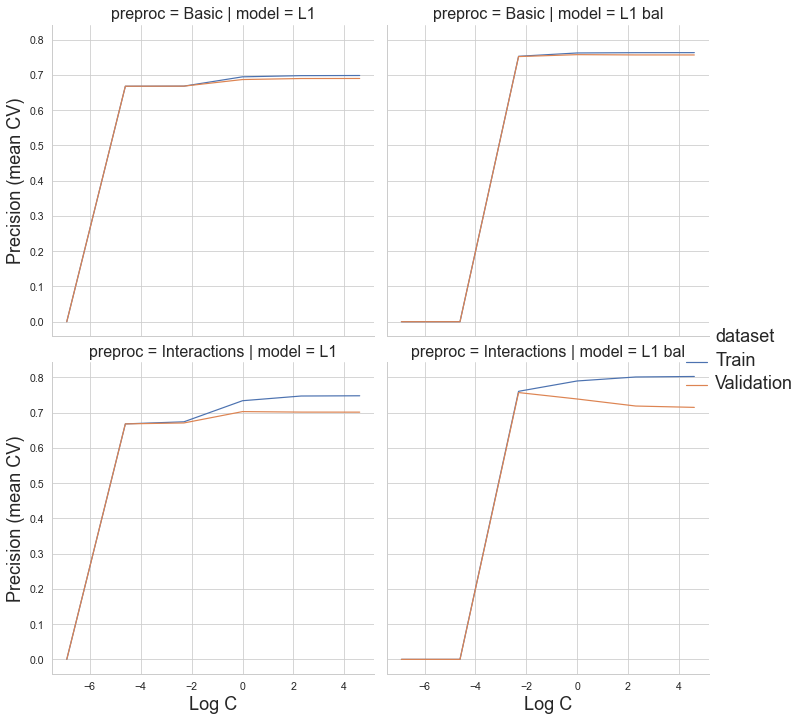

In [13]:
# figure of model comparisons on training  
plt.figure(figsize = (8, 10))
g = sns.relplot(data = grid_results_long[grid_results_long.metric == "precision"], 
                x = "log_C", y = 'score', 
                color = "black", hue = "dataset",  
                kind = "line", col = "model", row = "preproc")
g.set_xlabels("Log C", size = 18)
g.set_ylabels("Precision (mean CV)", size = 18)
plt.setp(g._legend.get_title(), fontsize = 18)
plt.setp(g._legend.get_texts(), fontsize = 18)
g.set_titles(size = 16)
plt.savefig(os.path.join(figure_path, "Grid_CV_learning_curves_precision.png"))

## Find the best model

In [14]:
best_metric = grid_results['mean_test_precision'].max()
best_model = pd.DataFrame(grid_results[grid_results['mean_test_precision']== best_metric])

print("Best precision: %0.3f" % best_metric)
print("Best PR AUC : %0.3f " % best_model['mean_test_average_precision'])
print("Best F1 score:%0.3f " % best_model['mean_test_f1'])
print("Best ROC AUC %0.3f " % best_model['mean_test_roc_auc'])
print("Best Recall %0.3f" % best_model['mean_test_recall'])
print("Best C parameter: %.3f" % best_model['param_model__C'])
print("Best model: %s with %s " % (best_model['model'], best_model['preproc']))


Best precision: 0.757
Best PR AUC : 0.756 
Best F1 score:0.725 
Best ROC AUC 0.632 
Best Recall 0.697
Best C parameter: 1.000
Best model: 15    L1 bal
Name: model, dtype: object with 15    Basic
Name: preproc, dtype: object 


## Validate model on hold-out test set
### define & fit the model 
- using entire train-validation set.
- need to pre-process the data first!

In [132]:
# define and fit the model 
best_LR_model = LogisticRegression(class_weight = "balanced",
                                   max_iter = 1000,
                                   penalty = 'l1', 
                                   solver = 'liblinear',
                                   C = 1)

# applying basic preprocessing - no interactions
preproc_X_trainval = preproc_basic.fit_transform(X_trainval)
preproc_X_test = preproc_basic.fit_transform(X_test)

# fit the model to the preprocessed train-validation set
best_LR_model.fit(preproc_X_trainval, y_trainval)
preproc_X_test.shape

(319, 9)

### get model scores on test set

In [133]:
y_pred = best_LR_model.predict(preproc_X_test)
print("Best Model scores on hold-out test set")
print(classification_report(y_test, y_pred))
#display(best_test_scores)# define and fit the model 


Best Model scores on hold-out test set
              precision    recall  f1-score   support

         0.0       0.44      0.61      0.51        80
         1.0       0.85      0.74      0.79       239

    accuracy                           0.71       319
   macro avg       0.64      0.67      0.65       319
weighted avg       0.75      0.71      0.72       319



In [101]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 49,  31],
       [ 63, 176]])

## Tuning the decision boundary 


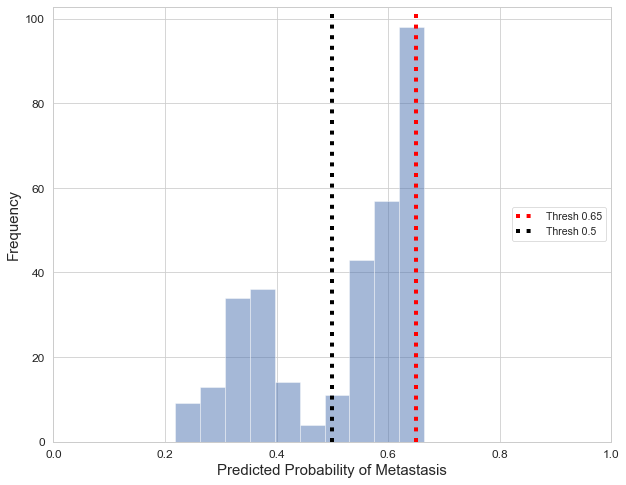

<Figure size 432x288 with 0 Axes>

In [46]:
# get predictions on hold-out test set.
key_thresh = 0.65
y_pred_prob = pd.DataFrame(best_LR_model.predict_proba(preproc_X_test))[1]
custom_plots.plot_predprobs(y_pred_prob, key_thresh ,
                           filename = os.path.join(figure_path, "best_LR_model_predprobs.png"))


/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


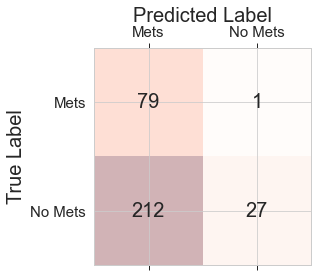

              precision    recall  f1-score   support

         0.0       0.27      0.99      0.43        80
         1.0       0.96      0.11      0.20       239

    accuracy                           0.33       319
   macro avg       0.62      0.55      0.31       319
weighted avg       0.79      0.33      0.26       319



In [47]:
y_pred_prob = pd.DataFrame(best_LR_model.predict_proba(preproc_X_test))[1]
y_pred_adjusted  = y_pred_prob > key_thresh
cm = confusion_matrix(y_test, y_pred_adjusted)
pretty_cm(cm, filename = os.path.join(figure_path, "best_LR_confusion_matrix_adjusted.png"))
print(classification_report(y_test, y_pred_adjusted))


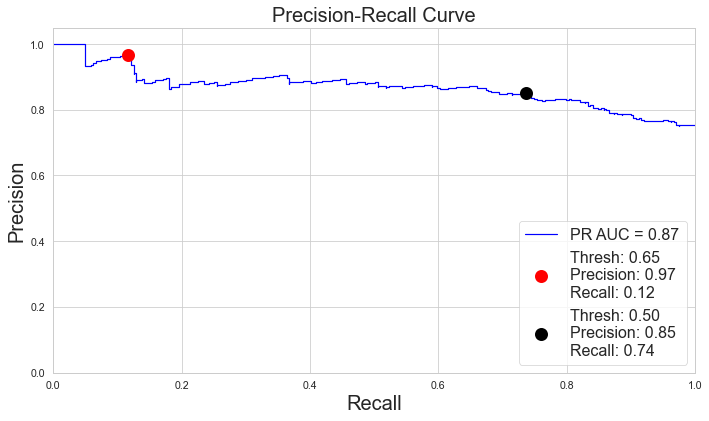

In [48]:
 
custom_plots.plot_pr_curve(y_test, y_pred_prob, key_thresh,
         filename = os.path.join(figure_path, "best_LR_PR_curve.png"))

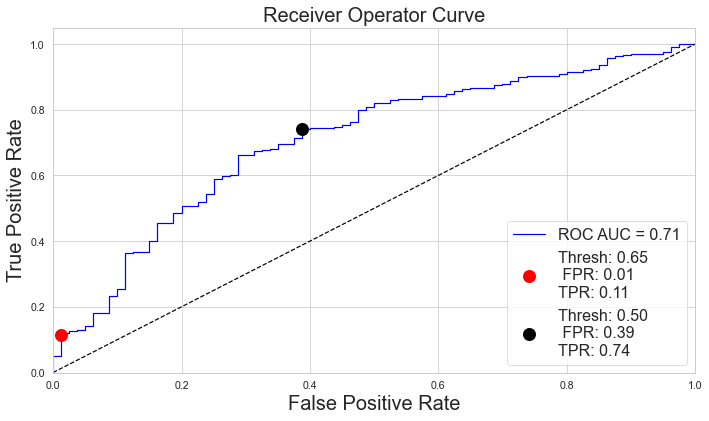

In [49]:
custom_plots.plot_roc_curve(y_test, y_pred_prob, key_thresh,
         filename = os.path.join(figure_path, "best_LR_ROC_curve.png"))

## Calibrate probabilities
- isotonic calibration is non-parametric, signmoid is parametric
- sigmoid works better.
- marginal improvement to brier score

In [55]:


# https://medium.com/analytics-vidhya/probability-calibration-essentials-with-code-6c446db74265
def plot_calibration_curve(est, name, method, fig_index, X_train, X_test, y_train, y_test, filename):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    calibrator = CalibratedClassifierCV(est, cv=2, method= method)

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(est, name),
                      (calibrator, name + ' +' + method)]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y_test.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives", size = 15)
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)', size = 20)

    ax2.set_xlabel("Mean predicted value", size = 16)
    ax2.set_ylabel("Count", size = 15)
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.savefig(filename, bbox_inches = 'tight')


sigmoid
Lasso Regression:
	Brier: 0.223
	Precision: 0.850
	Recall: 0.736
	F1: 0.789

Lasso Regression +sigmoid:
	Brier: 0.177
	Precision: 0.765
	Recall: 0.941
	F1: 0.844



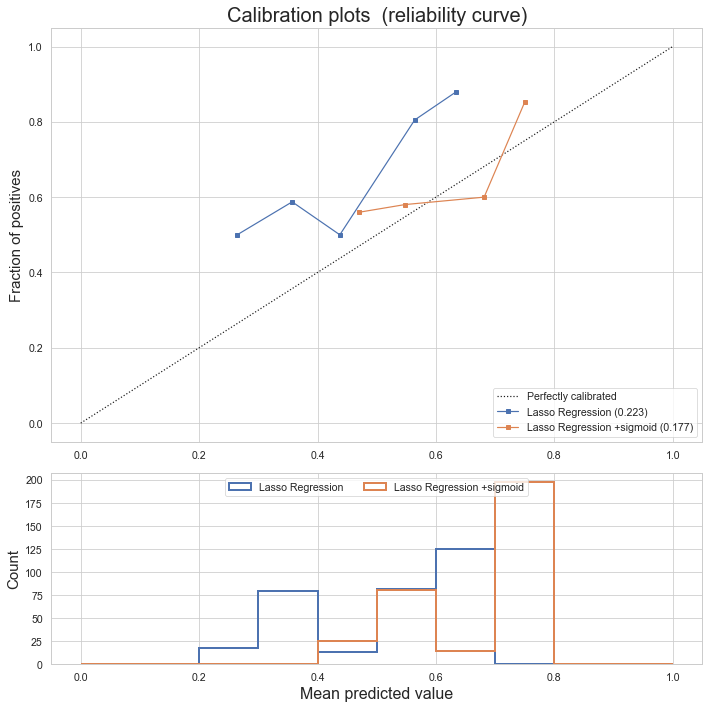

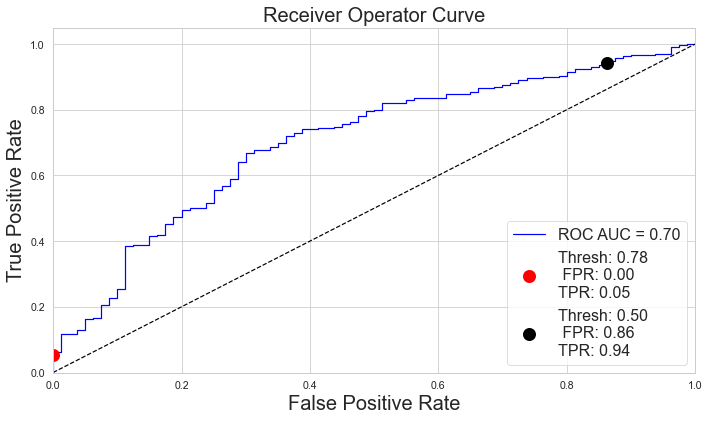

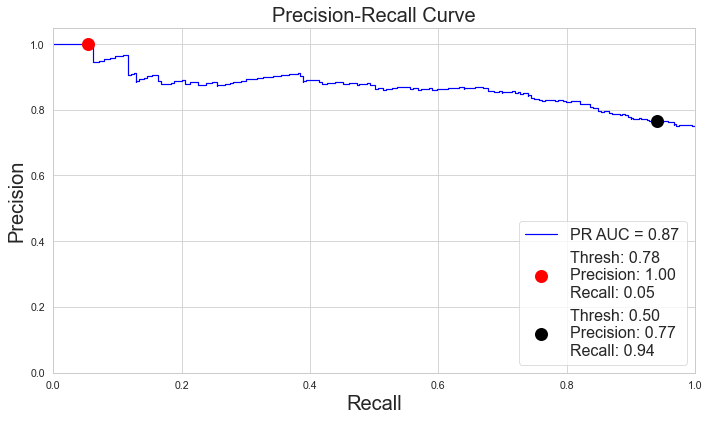

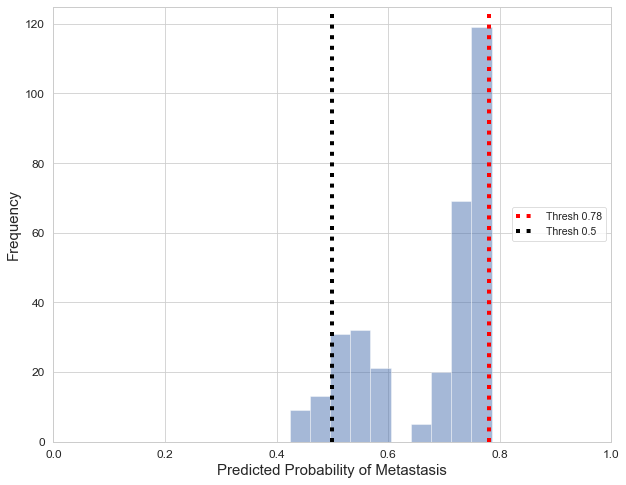

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


<Figure size 432x288 with 0 Axes>

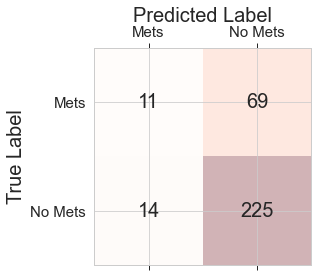

 sigmoid Calibrated with default threshold 
               precision    recall  f1-score   support

         0.0       0.44      0.14      0.21        80
         1.0       0.77      0.94      0.84       239

    accuracy                           0.74       319
   macro avg       0.60      0.54      0.53       319
weighted avg       0.68      0.74      0.69       319



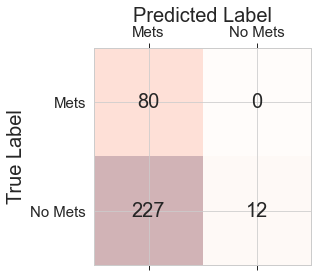

 sigmoid Calibrated with adjusted threshold 
               precision    recall  f1-score   support

         0.0       0.26      1.00      0.41        80
         1.0       1.00      0.05      0.10       239

    accuracy                           0.29       319
   macro avg       0.63      0.53      0.25       319
weighted avg       0.81      0.29      0.18       319

isotonic
Lasso Regression:
	Brier: 0.223
	Precision: 0.850
	Recall: 0.736
	F1: 0.789

Lasso Regression +isotonic:
	Brier: 0.175
	Precision: 0.787
	Recall: 0.883
	F1: 0.832



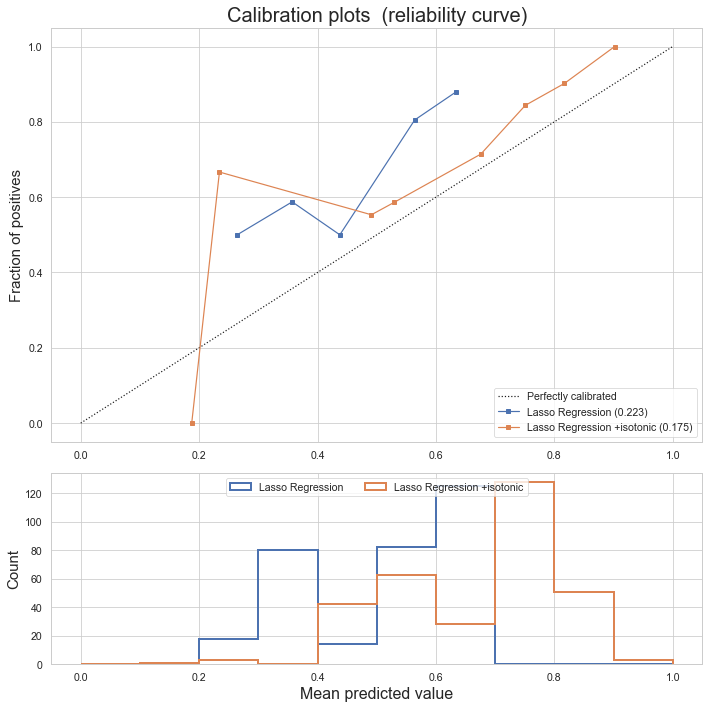

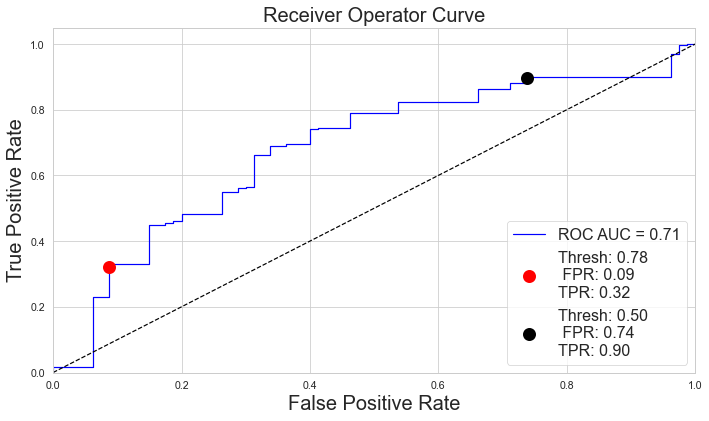

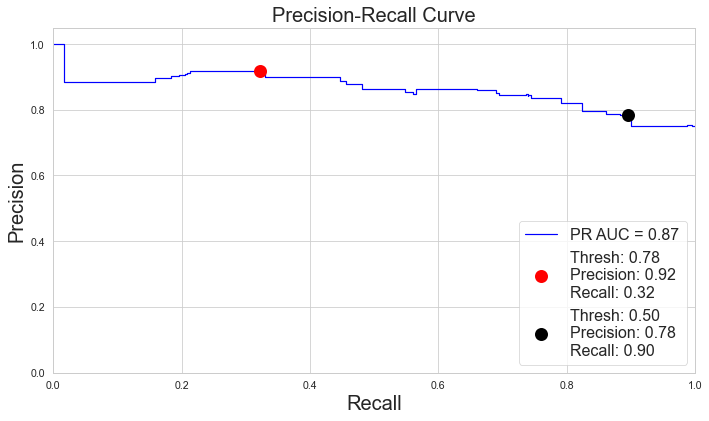

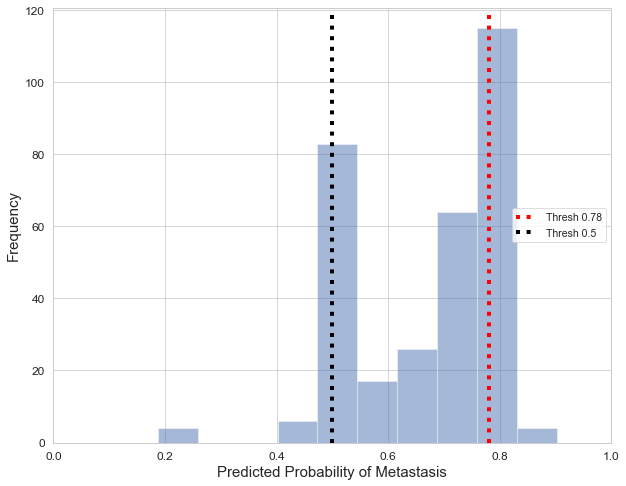

/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/Users/michellevantieghem2/.conda/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  


<Figure size 432x288 with 0 Axes>

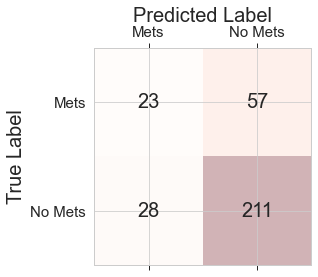

 isotonic Calibrated with default threshold 
               precision    recall  f1-score   support

         0.0       0.45      0.29      0.35        80
         1.0       0.79      0.88      0.83       239

    accuracy                           0.73       319
   macro avg       0.62      0.59      0.59       319
weighted avg       0.70      0.73      0.71       319



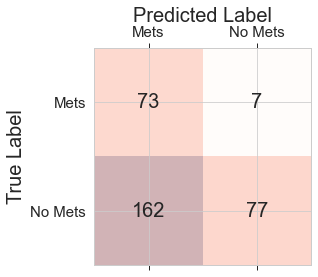

 isotonic Calibrated with adjusted threshold 
               precision    recall  f1-score   support

         0.0       0.31      0.91      0.46        80
         1.0       0.92      0.32      0.48       239

    accuracy                           0.47       319
   macro avg       0.61      0.62      0.47       319
weighted avg       0.76      0.47      0.47       319



In [54]:
key_thresh = .78
scale_methods = ['sigmoid', 'isotonic']
for method in scale_methods:
    print(method)
    calibrator = CalibratedClassifierCV(best_LR_model, cv = 2, method = method)
    calibrator.fit(preproc_X_trainval, y_trainval)
    calibrated_probs = calibrator.predict_proba(preproc_X_test)[:,1]
    y_pred_calibrated = calibrated_probs > 0.5
    y_pred_calibrated_adjusted = calibrated_probs > key_thresh

    plot_calibration_curve(best_LR_model, "Lasso Regression", method, 1,
                       preproc_X_trainval, preproc_X_test, y_trainval, y_test,
                      filename = os.path.join(figure_path, method,"best_LR_calibration_plot.png"))
    custom_plots.plot_roc_curve(y_test, calibrated_probs, key_thresh,
                           filename =  os.path.join(figure_path, method, "best_LR_ROC_curve_calibrated.png"))
    custom_plots.plot_pr_curve(y_test, calibrated_probs, key_thresh,
                          filename =  os.path.join(figure_path, method, "best_LR_PR_curve_calibrated.png"))
    custom_plots.plot_predprobs(calibrated_probs, key_thresh, 
                            filename = os.path.join(figure_path, method, "best_LR_predprobs_calibrated.png"))
    # defulal tthreshold
    cm = confusion_matrix(y_test, y_pred_calibrated)
    pretty_cm(cm, filename = os.path.join(figure_path,method, "best_LR_confusion_matrix_calibrated.png"))
    print(" %s calibrated with default threshold \n %s" %(method, classification_report(y_test, y_pred_calibrated)))

    # adjusted threshold
    cm = confusion_matrix(y_test, y_pred_calibrated_adjusted)
    pretty_cm(cm, filename = os.path.join(figure_path,method, "best_LR_confusion_matrix_calibrated_adjusted.png"))
    print(" %s calibrated with adjusted threshold \n %s" %(method, classification_report(y_test, y_pred_calibrated_adjusted)))



## Feature importance / coefficients
### obtain feature names from preprocessed data
- note: tumor_site was dummy-encoded, with "Extremity" as the reference.
- preprocessor changes order of variables

In [143]:

# get new feature order frorm preprocessor
preproc_feature_order = pd.DataFrame(modeling.get_feature_names(preprocessor))
preproc_feature_order.columns = ['variable']
preproc_feature_order['num'] = np.arange(start = 0, stop = 9, step = 1).astype('str')
preproc_feature_order['blah'] = 'x'
preproc_feature_order['index'] = preproc_feature_order.blah.str.cat(preproc_feature_order.num, sep = "")
preproc_feature_order.shape
preproc_X_test.shape

preproc_X_test_df = pd.DataFrame(preproc_X_test, columns = preproc_feature_order.variable)
preproc_X_test_df.head()

../mcc_metastasis/modeling.py:159: UserWarning: Transformer std_scaler (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  % (str(name), type(trans).__name__))


variable,num__AGE,num__tumor_size,onehot__x0_head_neck,onehot__x0_other,onehot__x0_trunk,SEX,tumor_lymphocytes,lymph_vasc_invasion,immuno_suppressed
0,-0.056368,-0.210214,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1,0.734025,-0.210214,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.635226,-0.210214,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.734025,-0.210214,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,-1.241958,-0.210214,0.0,0.0,0.0,1.0,0.0,1.0,0.0


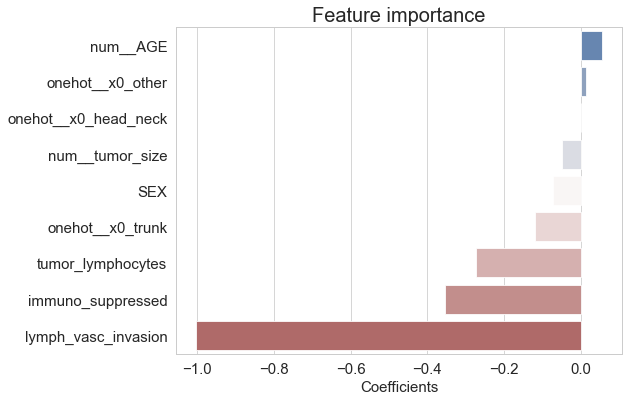

In [144]:
# apply custom function to get coefficients from model 
coefs_df = modeling.get_ordered_coefs(best_LR_model, preproc_X_test_df)
#coefs_df['abs_coefs'] = np.abs(coefs_df.coefs)
#impt_features = coefs_df[coefs_df.abs_coefs > 0.05]
custom_plots.plot_coefs(coefs_df, filename = os.path.join(figure_path, "best_LR_feature_weights.png"))


## Confirm findings with statsmodels 
### fit Lasso model on test set 
- need to add interccept explicitly to design matrix for statsmodels 
- they don't match perfectly because i am balancing class weights in sklearn!
- if i remove that, they are near identical.


In [142]:
# set up X and y as arrays 
# need to explicitly add constant (intercept) to X data 
intercept = ['intercept']
preproc_X_test_int = sm.add_constant(preproc_X_test_df)
y_test_array  = np.asarray(y_test)
preproc_X_test_int.head()

,const,num__AGE,num__tumor_size,onehot__x0_head_neck,onehot__x0_other,onehot__x0_trunk,SEX,tumor_lymphocytes,lymph_vasc_invasion,immuno_suppressed
0,1.0,-0.056368,-0.210214,1.0,0.0,0.0,1.0,1.0,1.0,1.0
1,1.0,0.734025,-0.210214,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.635226,-0.210214,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.734025,-0.210214,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,-1.241958,-0.210214,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [139]:
# re-creating best model 
# C = 0.1, so alpha is inverse, should be 10 
# C = 1,  alpha = 1 
# C = 100, alpha = 1 / 100 = 0.01
log_reg = sm.Logit(y_test_array, preproc_X_test_int)
lasso_model = log_reg.fit_regularized(method = 'l1', alpha = 1)
print(lasso_model.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5138665872149731
            Iterations: 61
            Function evaluations: 61
            Gradient evaluations: 61
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  319
Model:                          Logit   Df Residuals:                      310
Method:                           MLE   Df Model:                            8
Date:                Mon, 12 Oct 2020   Pseudo R-squ.:                  0.1147
Time:                        12:12:05   Log-Likelihood:                -159.05
converged:                       True   LL-Null:                       -179.66
Covariance Type:            nonrobust   LLR p-value:                 1.895e-06
                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------

In [140]:
sklearn_coef = pd.DataFrame( best_LR_model.coef_.T, columns = ["sklearn"])
# remove intercept coefficient from statmod 
statmod_coef = pd.DataFrame(lasso_model.params[1:10], columns = ["statmod"])


In [141]:
selected_sklearn = coefs_compare.features[abs(coefs_compare.sklearn) > 0.05]
selected_statmod = coefs_compare.features[abs(coefs_compare.statmod) > 0.05]
selected_statmod

AttributeError: 'DataFrame' object has no attribute 'features'

### sanity check, run regular logiistic regression in stats models
- they are identical as longg as you remove class_weights = "balanced"
- and use solver = lbfgs (instead of saga)

In [124]:
# define and fit the model 
regular_LR_model = LogisticRegression(max_iter = 1000,
                                   penalty = 'none', solver = 'lbfgs')

# applying the preprocessing to the X_trainval and X_test 
preproc_X_trainval = preprocessor.fit_transform(X_trainval)
# fit the model to the entire train-validation set
regular_LR_model.fit(preproc_X_trainval, y_trainval)

# confirming that sklearn adds an intercept! 
regular_LR_model.intercept_

array([-1.10832884])

In [125]:
log_reg = sm.Logit(y_trainval_array, preproc_X_trainval_int)
log_model = log_reg.fit()
print(log_model.summary())



Optimization terminated successfully.
         Current function value: 0.601594
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  691
Model:                          Logit   Df Residuals:                      681
Method:                           MLE   Df Model:                            9
Date:                Fri, 09 Oct 2020   Pseudo R-squ.:                 0.06301
Time:                        16:55:04   Log-Likelihood:                -415.70
converged:                       True   LL-Null:                       -443.65
Covariance Type:            nonrobust   LLR p-value:                 8.175e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1083      0.188     -5.903      0.000      -1.476      -0.740
x1            -0.2072      0.

In [126]:
sklearn_coef = pd.DataFrame(regular_LR_model.coef_.T, columns = ["sklearn"])
statmod_coef = pd.DataFrame(log_model.params[1:11], columns = ["statmod"])
features = pd.DataFrame(preproc_X_test_df.columns, columns = ["features"])
coefs_compare = pd.concat([features, sklearn_coef, statmod_coef],  axis = 1)

coefs_compare

,features,sklearn,statmod
0,Age,-0.207152,-0.207168
1,Tumor size (cm),0.089214,0.089212
2,Tumor site head/neck (vs extremity),-0.031362,-0.031337
3,Tumor site other (vs extremity),-0.151502,-0.151513
4,Tumor site trunk (vs extremity),0.556381,0.556424
5,Sex,-0.180049,-0.180049
6,Immuno suppressed,0.261345,0.261325
7,Tumor lymphocytes,0.330917,0.330907
8,Lymph vascular invasion,0.937038,0.937042
